# New York City Taxi Trip Duration

## Problem Statement

### Overview
This is a kaggle competition that challenges us to predict the taxi trip duration in New York city. Dataset is provided by the NYC taxi and Limousine commision for building a model.

Money prize: 30,000$.

Business motivation: providing good driving time estimation to
- Detect bottlenecks that appear in the taxi traffic network.
- Predict the taxi trip price. 

Input: a taxi trip with it's attributes. \
Output: trip duration in seconds. 
 
### Input and Output Data description

There are three files:
- train.csv: (1458644,11)
- test.csv: (625134,9)
- sample_submission.csv: (625134,2) 

| Column name | Description | 
| -------- | -------- | 
| id   | the id for each trip     |
| vendor_id   | the id provided Associated with the trip record     |
| pickup_datetime   | date and time when the meter was engaged     |
| dropoff_datetime   | date and time when the meter was disengaged    |
| passenger_count   | The number of passengers in the taxi    |
| pickup_longitude   | the longitude when the meter was engaged     |
| pickup_latitude   | the latitude when the meter was engaged   |
| dropoff_longitude   | the longitude when the meter was disengaged     |
| dropoff_latitude   | the latitude when the meter was disengaged     |
| store_and_fwd_flag   | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server  |
| trip_duration  | duration of the trip in seconds     |


- A record in train.csv

![](https://i.imgur.com/LtLFbTO.png)

- A record in test.csv
![](https://i.imgur.com/gEJR1jT.png)

- A record in sample_submission.csv
![](https://i.imgur.com/zwq0ezw.png)




### Evaluation Metric
- **Root Mean Squared Logarithmic Error** (RMSLE) is the metric was used to assess the result of this contest.

$$\epsilon = \sqrt{\frac{1}{n}\sum^{n}_{i=1}(log(p_i + 1) -log(a_i + 1)) ^2}$$

* With respect to:
    * $\epsilon$: RMSLE score
    * n: the number of records (trip duration's observations) in the dataset
    * $p_i$: the prediction of trip duration
    * $a_i$: the actual value of trip duration
    * log(x): natural logarithm (base is e)

* **The smaller the RMSLE value is, the better the model**.

In [1]:
# Crafting good features for XGBoost 

%matplotlib inline
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = [20, 15]

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
!unzip ../input/nyc-taxi-trip-duration/train.zip -d nyc-taxi-trip-duration
!unzip ../input/nyc-taxi-trip-duration/test.zip -d nyc-taxi-trip-duration
!unzip ../input/nyc-taxi-trip-duration/sample_submission.zip -d nyc-taxi-trip-duration

Archive:  ../input/nyc-taxi-trip-duration/train.zip
  inflating: nyc-taxi-trip-duration/train.csv  
Archive:  ../input/nyc-taxi-trip-duration/test.zip
  inflating: nyc-taxi-trip-duration/test.csv  
Archive:  ../input/nyc-taxi-trip-duration/sample_submission.zip
  inflating: nyc-taxi-trip-duration/sample_submission.csv  


In [4]:
np.random.seed(1987)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train = pd.read_csv('./nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('./nyc-taxi-trip-duration/test.csv')
sample_submission = pd.read_csv('./nyc-taxi-trip-duration/sample_submission.csv')

In [5]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663


In [6]:
test.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.99,40.73,-73.99,40.76,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.96,40.68,-73.96,40.66,N


In [7]:
def check_basic(df, df_type="train"):
    print("{} DF has {} rows and {} columns".format(df_type,df.shape[0], df.shape[1]))
    if df.id.nunique() == df.shape[0]:
        print("1. Id is unique")
    if not df.isnull().any().any(): 
        print("2. No missing value")
    if train.duplicated(keep='first').sum() == 0:
        print("3. No duplicate record")
    if df_type == 'train':
        trip_duration_diff = (pd.to_datetime(train.dropoff_datetime) - pd.to_datetime(train.pickup_datetime)).map(lambda x :x.total_seconds())
        if len(df[np.abs(trip_duration_diff.values - df['trip_duration'].values) > 1]) == 0:
            print("4. Trip_duration is consistent with pickup and dropoff times.")

In [8]:
check_basic(train, df_type="train")

train DF has 1458644 rows and 11 columns
1. Id is unique
2. No missing value
3. No duplicate record
4. Trip_duration is consistent with pickup and dropoff times.


In [9]:
check_basic(test, df_type="test")

test DF has 625134 rows and 9 columns
1. Id is unique
2. No missing value
3. No duplicate record


In [10]:
print("Train:\n", train.dtypes, "\n")
print("Test:\n", test.dtypes)

Train:
 id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object 

Test:
 id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object


* Convert string type to datetime

In [11]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

In [12]:
print("Train:\n", train.dtypes, "\n")
print("Test:\n", test.dtypes)

Train:
 id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object 

Test:
 id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
dtype: object


In [13]:
train.describe(datetime_is_numeric = True)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644,1458644,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,2016-04-01 10:10:24.940037120,2016-04-01 10:26:24.432310528,1.66,-73.97,40.75,-73.97,40.75,959.49
min,1.00,2016-01-01 00:00:17,2016-01-01 00:03:31,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,2016-02-17 16:46:04.249999872,2016-02-17 17:05:32.500000,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,2016-04-01 17:19:40,2016-04-01 17:35:12,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2016-05-15 03:56:08.750000128,2016-05-15 04:10:51.750000128,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,2016-06-30 23:59:39,2016-07-01 23:02:03,9.00,-61.34,51.88,-61.34,43.92,3526282.00
std,0.50,NaN,NaN,1.31,0.07,0.03,0.07,0.04,5237.43


In [14]:
num_cols = list(train.select_dtypes(exclude='object').columns)
cate_cols = list(train.select_dtypes(include='object').columns)
print("Num cols: ",num_cols)
print("Cate cols: ",cate_cols)

Num cols:  ['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']
Cate cols:  ['id', 'store_and_fwd_flag']


### Numerical columns

In [15]:
def missing_percentage(col):
    per = col.isna().mean()*100
    return per.round(1)

def value_percentages(col):
    val = col.groupby(by=col).count().sort_values(ascending=False)
    total = val.sum()
    return (((val / total)*100).round(1)).to_dict()

def num_values(col):
    return col.nunique()

In [16]:
train[num_cols].agg([missing_percentage, value_percentages, num_values])

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
missing_percentage,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
value_percentages,"{2: 53.5, 1: 46.5}","{2016-03-04 08:07:34: 0.0, 2016-01-12 18:48:44...","{2016-02-19 19:25:04: 0.0, 2016-05-16 19:40:28...","{1: 70.9, 2: 14.4, 5: 5.4, 3: 4.1, 6: 3.3, 4: ...","{-73.9822006225586: 0.0, -73.98213958740233: 0...","{40.77410125732422: 0.0, 40.774089813232415: 0...","{-73.98233032226561: 0.0, -73.98209381103516: ...","{40.774311065673835: 0.0, 40.77433013916016: 0...","{368: 0.1, 408: 0.1, 348: 0.1, 367: 0.1, 358: ..."
num_values,2,1380222,1380377,10,23047,45245,33821,62519,7417


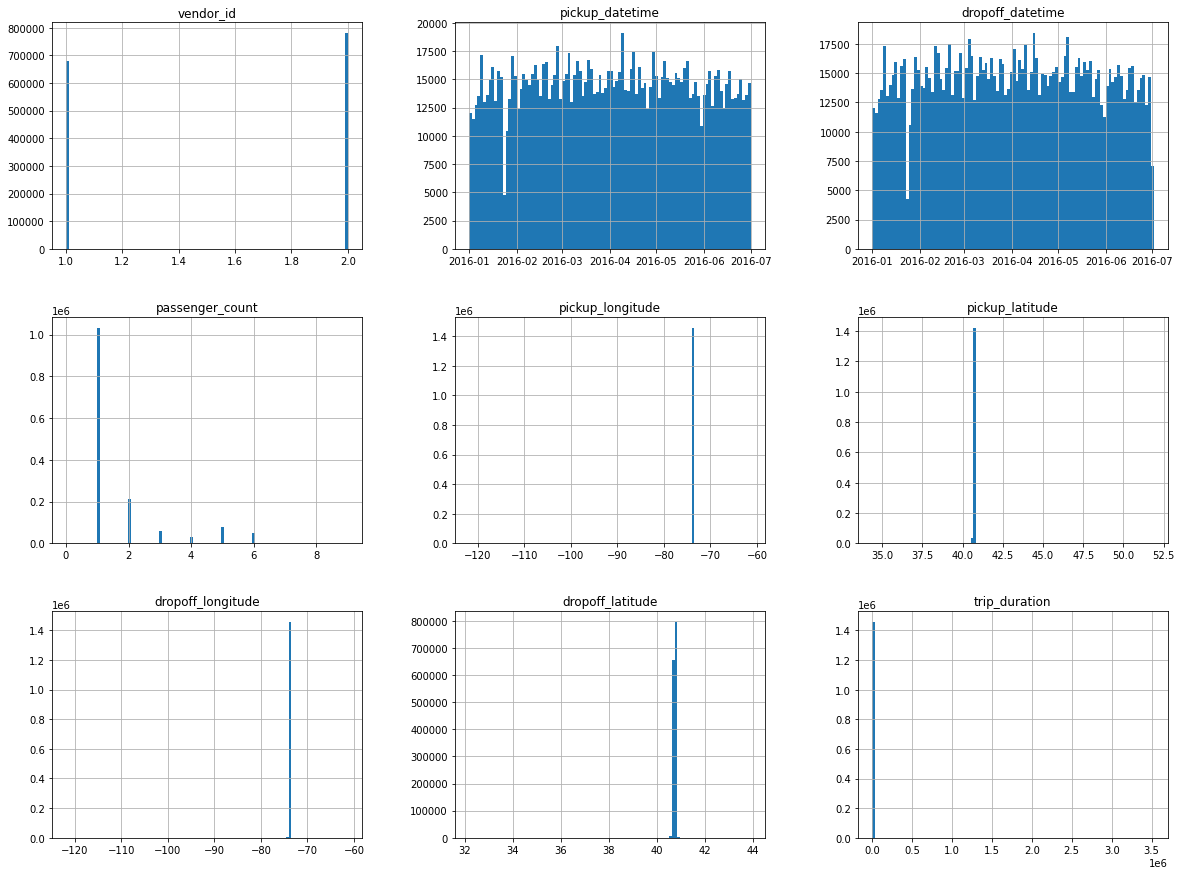

In [17]:
train[num_cols].hist(figsize=(20, 15), bins = 100)
plt.show()

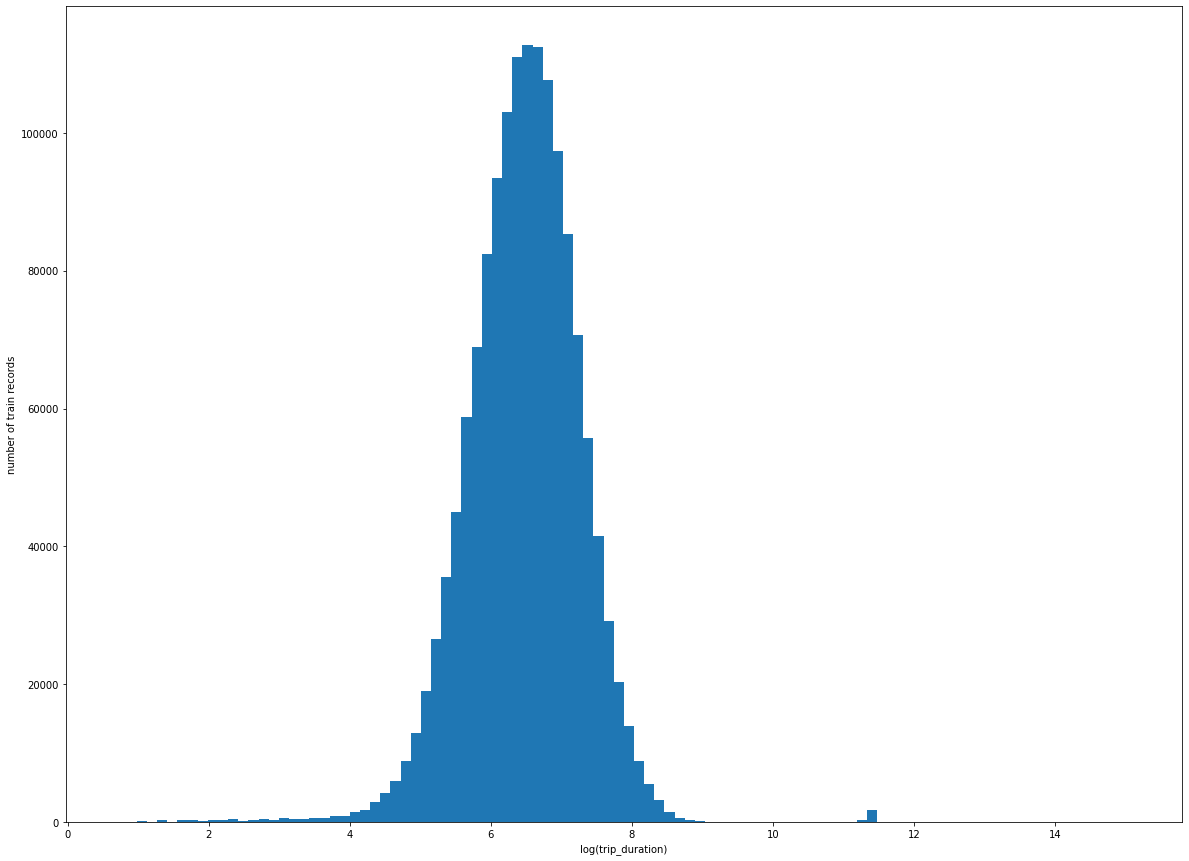

In [18]:
train_log_trip_duration = np.log(train['trip_duration'].values + 1)
plt.hist(train_log_trip_duration, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [19]:
def getColor(len_com):
    lstColor = []
    for i in range(len_com):
        color = '#'+''.join([random.choice('ABCDEF0123456789') for j in range(6)])
        while color in lstColor:
            color = '#'+''.join([random.choice('ABCDEF0123456789') for j in range(6)])
            lstColor.append(color)
    return lstColor

In [20]:
def draw_chart(df, fig_size = (20,15)):
    temp = list(df.columns)
    figure, axis = plt.subplots(len(temp)//2 if len(temp) % 2 == 0 else len(temp)//2 + 1, 2, figsize = fig_size)
    color = ['#582f0e','#936639','#f3722c','#c2c5aa','#414833','#457b9d','#ffb703','#e63946', '#c77dff','#55a630','#f72585','#ffa69e','#4d908e','#7f5539','#b5e48c','#b6ad90','#38b000']
    for i, col in enumerate(temp):
        t = df[col].value_counts()
        axis[i//2, i%2].scatter(list(t.index), t.values, color = color[i])
        axis[i//2, i%2].set_title(col)
    if len(temp) %2 !=0:
        figure.delaxes(axis[len(temp)//2,1])
    plt.show()

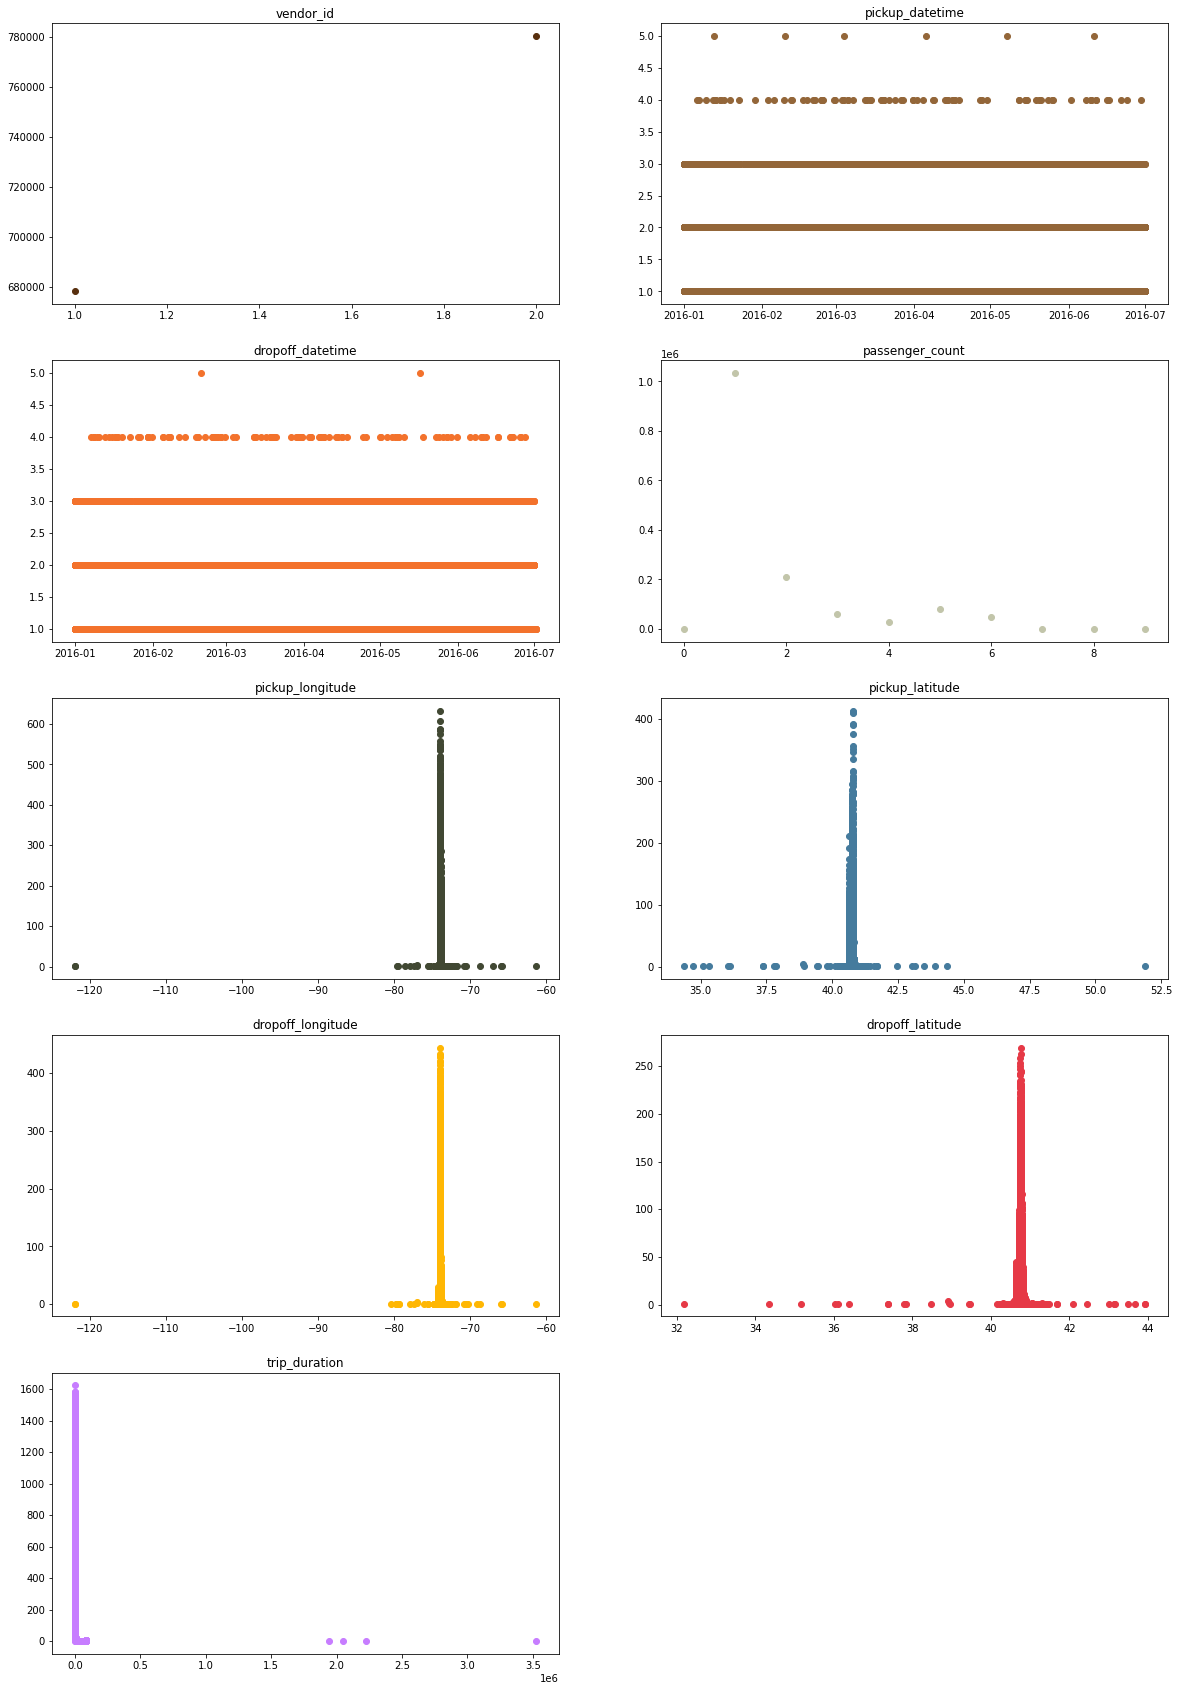

In [21]:
draw_chart(train[num_cols], (20,30));

### Categorical columns

In [22]:
train[cate_cols].agg([missing_percentage, value_percentages, num_values])

,id,store_and_fwd_flag
missing_percentage,0.00,0.00
value_percentages,"{'id0000001': 0.0, 'id2665099': 0.0, 'id266515...","{'N': 99.4, 'Y': 0.6}"
num_values,1458644,2


* Because the **store_and_fwd_flag** column only contains two unique values, **"Y"** and **"N"**, we will convert it to **1** and **0**, respectively. (In train and test set)

In [23]:
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

In [24]:
print("Train:\n", train.dtypes, "\n")
print("Test:\n", test.dtypes)

Train:
 id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
dtype: object 

Test:
 id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
dtype: object


# OSRM features

In [25]:
osrm_train = pd.read_csv('../input/nyc-taxi-trip-noisy/train_augmented.csv')
osrm_test = pd.read_csv('../input/nyc-taxi-trip-noisy/test_augmented.csv')
print("OSRM Train shape: ", osrm_train.shape)
print("OSRM Test shape: ", osrm_test.shape)

OSRM Train shape:  (1458643, 16)
OSRM Test shape:  (625134, 16)


* Definition of each column

| Column name | Description | 
| -------- | -------- | 
| id   | Record id     |
| distance | Route distance (m) |
| duration | OSRM trip duration (s) |
| motorway | The proportion spent on different kind of roads (% of total distance) |
| trunk |  The proportion spent on different kind of roads (% of total distance) |
| primary | The proportion spent on different kind of roads (% of total distance) |
| secondary | The proportion spent on different kind of roads (% of total distance) |
| tertiary | The proportion spent on different kind of roads (% of total distance) |
| unclassified | The proportion spent on different kind of roads (% of total distance) |
| residential | The proportion spent on different kind of roads (% of total distance) |
| nTrafficSignals | The number of traffic signals |
| nCrossing | The number of pedestrian crossing |
| nStop | The number of stop signs |
| nIntersection | The number of intersections, if you are OSRM user, intersection have different meaning than the one used in OSRM |
| srcCounty | Pickup county |
| dstCounty | Dropoff county |

* **srcCounty** and **dstCounty** values: There are 6 different values
    * NA: Not in NYC
    1. Brooklyn
    2. Queens
    3. Staten Island
    4. Manhattan
    5. Bronx

$\Rightarrow$ We will fill in NA values with the number 6.

In [26]:
osrm_train.srcCounty.fillna(6, inplace = True)
osrm_train.dstCounty.fillna(6, inplace = True)
osrm_test.srcCounty.fillna(6, inplace = True)
osrm_test.dstCounty.fillna(6, inplace = True)

In [27]:
osrm_train.dtypes

id                  object
distance           float64
duration           float64
motorway           float64
trunk              float64
primary            float64
secondary          float64
tertiary           float64
unclassified       float64
residential        float64
nTrafficSignals      int64
nCrossing            int64
nStop                int64
nIntersection        int64
srcCounty          float64
dstCounty          float64
dtype: object

In [28]:
osrm_test.dtypes

id                  object
distance           float64
duration           float64
motorway           float64
trunk              float64
primary            float64
secondary          float64
tertiary           float64
unclassified       float64
residential        float64
nTrafficSignals      int64
nCrossing            int64
nStop                int64
nIntersection        int64
srcCounty          float64
dstCounty          float64
dtype: object

In [29]:
osrm_train.head(2)

,id,distance,duration,motorway,trunk,primary,secondary,tertiary,unclassified,residential,nTrafficSignals,nCrossing,nStop,nIntersection,srcCounty,dstCounty
0,id2875421,2009.10,160.90,0.00,0.00,0.00,0.00,1.00,0.00,0.00,14,5,0,4,1.00,1.00
1,id2377394,2513.40,256.50,0.00,0.00,0.00,0.35,0.17,0.00,0.14,25,13,0,0,1.00,1.00


In [30]:
print(len(np.intersect1d(osrm_train['id'], train['id'])))
print(train.shape[0])

1458643
1458644


* The number of ids in osrm_train is less than the origin train set 1 id, every id in osrm_train are in train set.

In [31]:
osrm_train.describe()

,distance,duration,motorway,trunk,primary,secondary,tertiary,unclassified,residential,nTrafficSignals,nCrossing,nStop,nIntersection,srcCounty,dstCounty
count,1458643.00,1458643.00,1458643.00,1458643.00,1458643.00,1458643.00,1458643.00,1458643.00,1458643.00,1458643.00,1458643.00,1458643.00,1458643.00,1458643.00,1458643.00
mean,4569.43,343.50,0.00,0.13,0.03,0.27,0.42,0.01,0.04,24.50,8.81,0.12,2.52,1.22,1.29
std,5482.10,301.02,0.01,0.26,0.12,0.31,0.35,0.06,0.12,14.67,9.26,0.46,5.23,0.76,0.85
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
25%,1653.90,155.40,0.00,0.00,0.00,0.00,0.08,0.00,0.00,14.00,2.00,0.00,0.00,1.00,1.00
50%,2729.70,249.20,0.00,0.00,0.00,0.13,0.35,0.00,0.00,21.00,6.00,0.00,1.00,1.00,1.00
75%,5048.85,424.00,0.00,0.00,0.00,0.46,0.76,0.00,0.02,32.00,13.00,0.00,3.00,1.00,1.00
max,1038310.00,46645.30,1.00,1.00,1.00,1.00,1.00,1.00,1.00,112.00,91.00,10.00,132.00,6.00,6.00


In [32]:
osrm_num_cols = list(osrm_train.select_dtypes(exclude = 'object').columns)
osrm_cate_cols = list(osrm_train.select_dtypes(include = 'object').columns)

In [33]:
osrm_train[osrm_num_cols].agg([missing_percentage, value_percentages, num_values])

,distance,duration,motorway,trunk,primary,secondary,tertiary,unclassified,residential,nTrafficSignals,nCrossing,nStop,nIntersection,srcCounty,dstCounty
missing_percentage,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
value_percentages,"{0.0: 0.4, 0.4: 0.0, 0.2: 0.0, 0.3: 0.0, 0.7: ...","{0.0: 0.5, 0.1: 0.0, 153.7: 0.0, 152.9: 0.0, 1...","{0.0: 98.8, 1.0: 0.0, 0.0895147: 0.0, 0.410127...","{0.0: 77.4, 1.0: 0.0, 0.843357: 0.0, 0.868216:...","{0.0: 90.3, 1.0: 0.0, 0.318393: 0.0, 0.0372789...","{0.0: 28.5, 1.0: 2.7, 0.132881: 0.0, 0.2: 0.0,...","{0.0: 12.8, 1.0: 6.0, 0.00344565: 0.0, 0.33333...","{0.0: 89.0, 1.0: 0.0, 0.0203159: 0.0, 0.659213...","{0.0: 67.1, 1.0: 0.2, 0.137491: 0.0, 0.0909091...","{16: 3.5, 15: 3.5, 14: 3.4, 17: 3.4, 13: 3.4, ...","{0: 16.2, 2: 9.2, 4: 6.8, 3: 5.7, 5: 5.4, 6: 4...","{0: 91.6, 1: 6.4, 2: 1.4, 3: 0.4, 7: 0.1, 4: 0...","{0: 45.3, 1: 18.4, 2: 10.3, 3: 5.4, 4: 4.7, 5:...","{1.0: 92.1, 4.0: 5.9, 3.0: 1.8, 2.0: 0.1, 6.0:...","{1.0: 88.4, 3.0: 5.3, 4.0: 5.2, 2.0: 0.6, 6.0:..."
num_values,195168,18645,17242,266611,132468,705224,776903,146442,397757,113,85,11,113,6,6


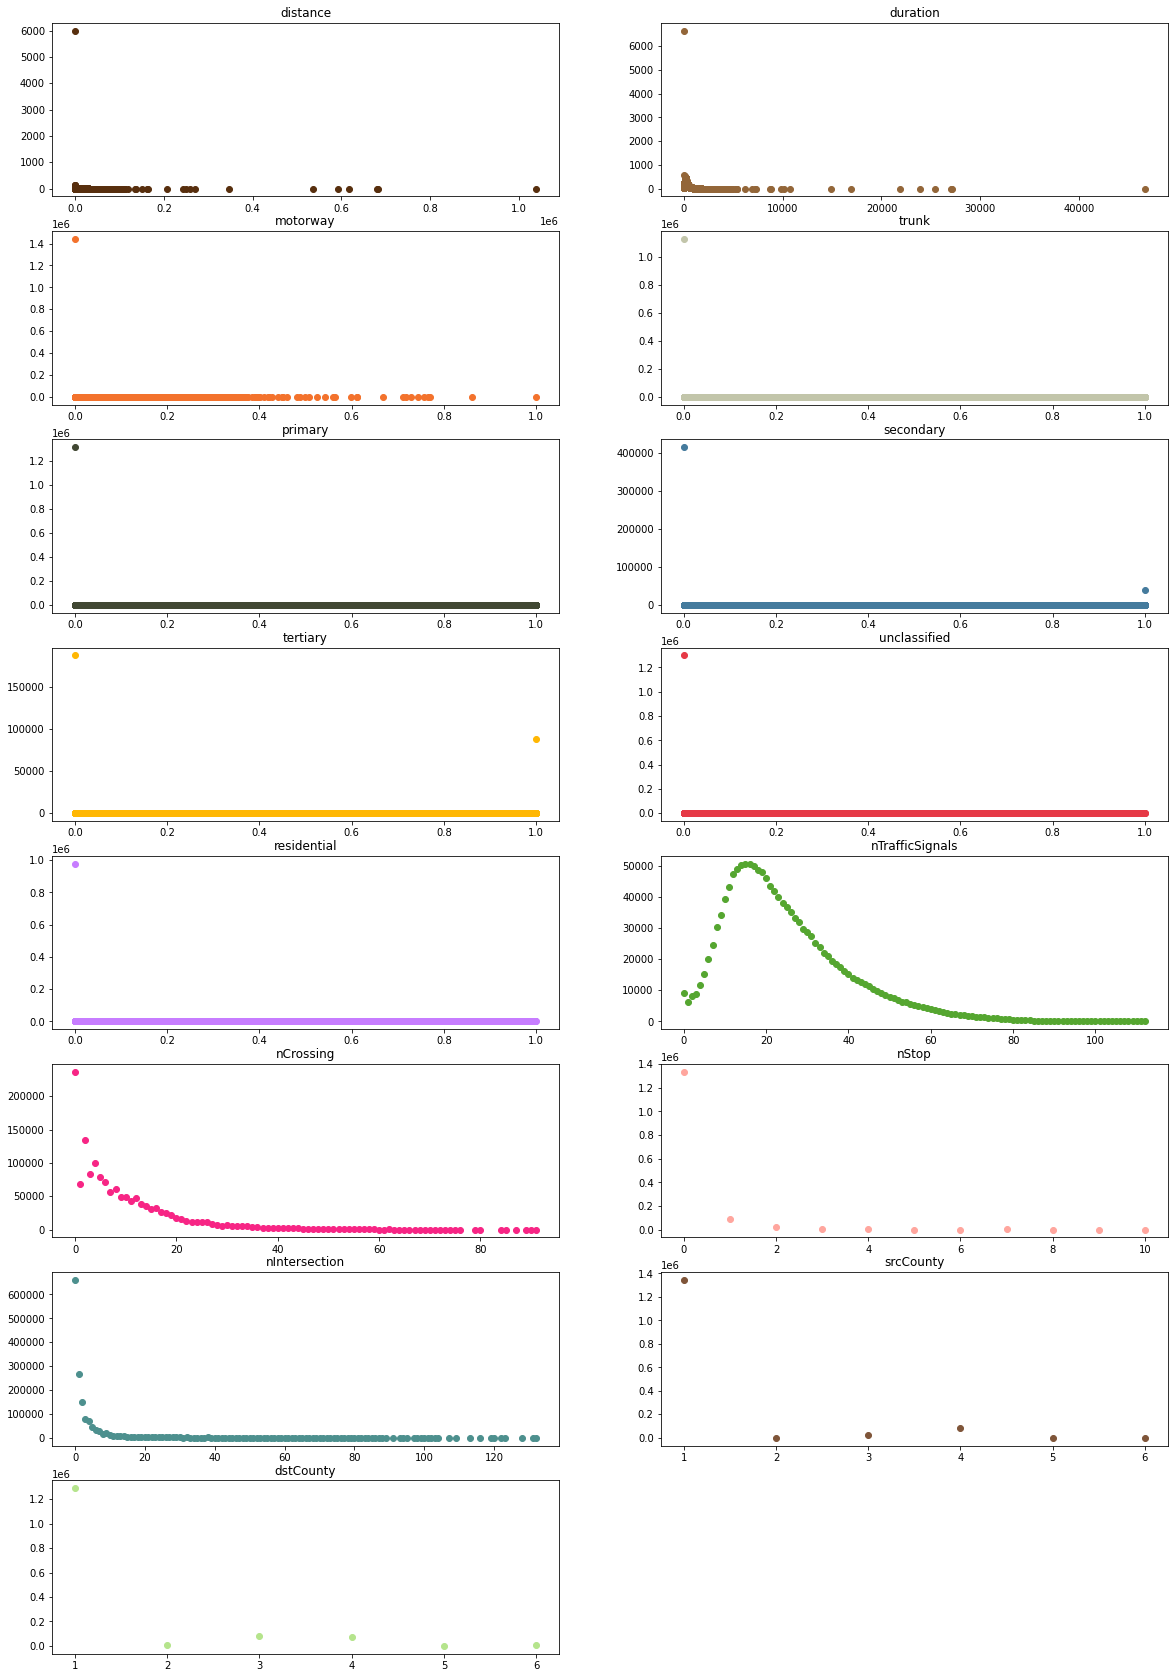

In [34]:
draw_chart(osrm_train.select_dtypes(exclude='object'),(20,30))